In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.3.1


In [7]:
%%bigquery flights_df --verbose
SELECT 
    date
    , airline
    , departure_airport
    , arrival_airport
    , departure_lat
    , departure_lon
    , arrival_lat
    , arrival_lon
    , departure_delay
    , arrival_delay
FROM `bigquery-samples.airline_ontime_data.flights`
WHERE departure_airport = 'SFO' AND date >= '2009-01-01' AND date <= '2009-12-31'

Executing query with job ID: f5528b4e-8ca1-421e-a4be-068b95b51052
Query executing: 3.61s
Query complete after 3.98s


In [8]:
flights_df.shape

(134990, 10)

In [9]:
flights_df.head()

,date,airline,departure_airport,arrival_airport,departure_lat,departure_lon,arrival_lat,arrival_lon,departure_delay,arrival_delay
0,2009-09-29,CO,SFO,EWR,37.61,-122.37,40.69,-74.16,-3.0,-28.0
1,2009-09-29,CO,SFO,EWR,37.61,-122.37,40.69,-74.16,10.0,-13.0
2,2009-09-29,CO,SFO,EWR,37.61,-122.37,40.69,-74.16,-5.0,-16.0
3,2009-09-07,CO,SFO,EWR,37.61,-122.37,40.69,-74.16,6.0,-4.0
4,2009-09-29,CO,SFO,EWR,37.61,-122.37,40.69,-74.16,-6.0,-16.0


In [10]:
type(flights_df)

pandas.core.frame.DataFrame

In [17]:
processed_df = (flights_df
                 .query('1 <= departure_delay <= 120')
                 .dropna()
                 .filter(['departure_delay', 'arrival_delay'])
                )

In [18]:
print(processed_df)

        departure_delay  arrival_delay
1                  10.0          -13.0
3                   6.0           -4.0
9                   3.0           11.0
10                  1.0           -4.0
11                  1.0           17.0
...                 ...            ...
134979             33.0           46.0
134980              9.0           18.0
134981              1.0           10.0
134982             52.0           38.0
134988              1.0            2.0

[47785 rows x 2 columns]


<AxesSubplot:xlabel='departure_delay', ylabel='arrival_delay'>

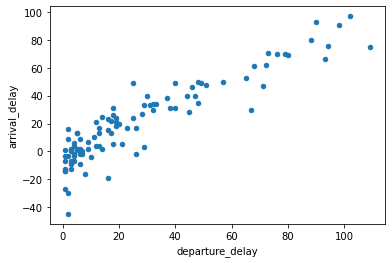

In [19]:
(processed_df
.sample(n=100, random_state=123)
.plot.scatter('departure_delay', 'arrival_delay'))

In [21]:
train_df = processed_df.sample(frac=0.8, random_state=123)
# 80% of data in training df
test_df = processed_df.drop(train_df.index)
# testing df is main df minus the indecies of the training set
train_labels = train_df.pop('arrival_delay')
test_labels = test_df.pop('arrival_delay')

In [26]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='linear', input_shape=[len(train_df.keys())])
])
# linear regression is actually a single neuron (tensor, matrix) with linear activation

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)
# optimize by mean squared error and root mean squared

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.get_weights()
# weight should be randomly initialized, bias is set to 0 

[array([[-1.4506736]], dtype=float32), array([0.], dtype=float32)]

In [33]:
example_batch = train_df[:5]
model.predict(example_batch)
# should be able to predict immediately, but will be bad

array([[  -7.253368 ],
       [ -33.365494 ],
       [  -1.4506736],
       [  -4.3520207],
       [-136.36331  ]], dtype=float32)

In [34]:
trained_data = model.fit(train_df, train_labels,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.TensorBoard('logs/simple-regression')])

Epoch 1/10
   1/1195 [..............................] - ETA: 0s - loss: 9569.7188 - mean_absolute_error: 66.3843 - mean_squared_error: 9569.7188WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1195/1195 [==============================] - 2s 2ms/step - loss: 5497.8984 - mean_absolute_error: 49.3670 - mean_squared_error: 5497.8984
Epoch 2/10
1195/1195 [==============================] - 2s 2ms/step - loss: 1012.2496 - mean_absolute_error: 20.9873 - mean_squared_error: 1012.2496
Epoch 3/10
1195/1195 [==============================] - 3s 2ms/step - loss: 185.7408 - mean_absolute_error: 10.2621 - mean_squared_error: 185.7408
Epoch 4/10
1195/1195 [==============================] - 2s 2ms/step - loss: 178.3718 - mean_absolute_error: 9.9750 - mean_squared_error: 178.371

In [35]:
model.get_weights()

[array([[0.96859664]], dtype=float32), array([-3.8965764], dtype=float32)]

In [38]:
# y = 0.97x - 3.90
# mean absolute error converges around 9
test_predictions = model.predict(test_df).flatten()
# flattening concatenates multi-dimensional matrix into 1D (or ND)
results_df = pd.DataFrame({ 'Predicted': test_predictions, 'Actual': test_labels })
results_df.head(5)

,Predicted,Actual
1,5.789390,-13.0
11,-2.927980,17.0
48,0.946407,14.0
58,-2.927980,-22.0
81,36.784481,49.0


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

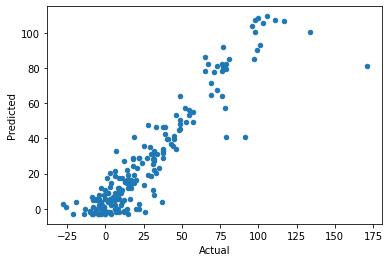

In [40]:
(results_df.sample(n=200, random_state=123).plot.scatter('Actual', 'Predicted'))

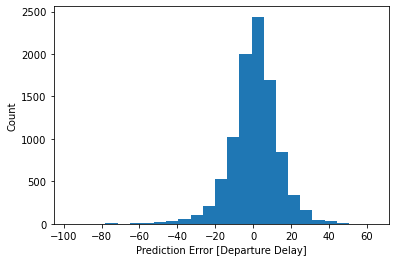

In [41]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Departure Delay]')
_ = plt.ylabel('Count')

In [42]:
# model may be too optimistic when the the flight departs early (negative value)
test_MAE = abs(error).mean()
test_MAE

9.190879370623133

In [44]:
# off by about 9 minutes, kinda bad, may need more FEATURES

In [45]:
pip install geopy

     |████████████████████████████████| 111 kB 9.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [46]:
import geopy.distance
coords_1 = (38.94, -77.46)
coords_2 = (40.77, -73.87)

In [48]:
geopy.distance.distance(coords_1, coords_2).km

368.27546093077206

In [68]:
# create distance function, because lat/lng don't mean much by themselves
# preprocessing speeds up convergence
def coords_to_distance(row):
    coords_start = (row['departure_lat'], row['departure_lon'])
    coords_end = (row['arrival_lat'], row['arrival_lon'])
    distance = geopy.distance.distance(coords_start, coords_end).km
    return(distance)

# creates new key for departure/arrival airport, since distances should be the same for each pair
def get_route_key(row):
    return row['departure_airport'] + row['arrival_airport']

# get relevant columns, drop duplicates, and create route key
distances_df = (flights_df[['departure_airport', 'arrival_airport', 'departure_lat', 'departure_lon', 'arrival_lat', 'arrival_lon']]
                .drop_duplicates()
                .assign(route_key=get_route_key))

# apply distance function to df, and grab distance and route key
distances_df['distance'] = distances_df.apply(coords_to_distance, axis=1)
distances_df = distances_df[['route_key', 'distance']]

# remove outliers, get route key, merge with distances, return correct columns
flights_processed_df = (flights_df
                        .query('1 <= departure_delay <= 120')
                        .assign(route_key=get_route_key)
                        .merge(distances_df)
                        .dropna()
                        .filter(['departure_delay', 'arrival_delay', 'distance']))

In [70]:
# this is multiple linear regression (multiple input variables)
flights_processed_df.head()

,departure_delay,arrival_delay,distance
0,10.0,-13.0,4129.108477
1,6.0,-4.0,4129.108477
2,3.0,11.0,4129.108477
3,1.0,-4.0,4129.108477
4,1.0,17.0,4129.108477
